<a href="https://colab.research.google.com/github/KhaingLae/TensorFlow_DeepLearning_Bootcamp/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learing with TensorFlow Part 3: Scaling up ( 🍔 👁 Food Vision mini)

We've seen the power of transfer learning feature extraction and fine-tuning, now it's time to scale up all of the classes in Food101 (101 total classes of food).

Our goal is to beat the original Food101 paper with 10% of the training (leveraging the power of deep learning).

Original Food101 paper:
https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

Our baseline to beat is 50.76% accuracy across 101 classes

## Creating helper functions


In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py


--2025-04-11 08:49:16--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-04-11 08:49:16 (118 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# import series of helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir, compare_historys

## 101 Food Classes: working with less data

The data we're downloading comes from original 101 data but has been prepocessed using the image_data_modification notebook:
https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb


In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2025-04-11 08:49:25--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.170.207, 74.125.68.207, 142.251.175.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.170.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  22.9MB/s    in 70s     

2025-04-11 08:50:36 (22.2 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/guacamole'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/frozen_yogurt'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/strawberry_shortcake'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/risotto'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/bruschetta'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/chocolate_cake'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/clam_chowder'.
There are 0 directories and 250 image

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                                 image_size=IMG_SIZE,
                                                                                 label_mode="categorical",
                                                                                 batch_size=32)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                 image_size=IMG_SIZE,
                                                                 label_mode="categorical",
                                                                 shuffle="False")


Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model

Here are the steps we're going to take:
* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientNetB0 backboned model
* Compile our model
* Feature extract for 5 full passess (5 epochs on the train dataset, validate on the 15% of test data)

In [ ]:
# Create checkpoint callback
checkpont_path= "101_classes_10_percent_data_model_checkpoint.keras"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpont_path,
                                                          save_best_only=True,
                                                          monitor="val_accuracy")

In [ ]:
# Create data argumentation layer
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Setup data argumentation
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  #layers.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetV2B0,
  # but if we remove, I got inputtype missmatch error in 05 session, that'why I add this
  # but after adding this, model performance is bad, so I remove again :)
], name ="data_augmentation")

In [ ]:
# Setup the base model and freeze its layers (this will extract feature)
base_model = tf.keras.applications.EfficientNetB0(include_top= False)
base_model.trainable= False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training = False) # put the base model frozen
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x)

# Get the number of classes from the dataset's element spec
# num_classes = train_data_all_10_percent.element_spec[1].shape[1]
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, None, None,     │     4,049,571 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling          │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 101)            │       129,381 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
# Compile
model.compile(optimizer= tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                            epochs=5,
                                            validation_data=test_data,
                                            validation_steps=int(0.15 * len(test_data)),
                                            callbacks=[checkpoint_callback])

Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 59s 178ms/step - accuracy: 0.1595 - loss: 3.9761 - val_accuracy: 0.4542 - val_loss: 2.3867
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 37s 156ms/step - accuracy: 0.4815 - loss: 2.3240 - val_accuracy: 0.5095 - val_loss: 1.9448
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 42s 162ms/step - accuracy: 0.5562 - loss: 1.9002 - val_accuracy: 0.5453 - val_loss: 1.7666
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 40s 157ms/step - accuracy: 0.6020 - loss: 1.6863 - val_accuracy: 0.5617 - val_loss: 1.6810
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 40s 153ms/step - accuracy: 0.6209 - loss: 1.5437 - val_accuracy: 0.5689 - val_loss: 1.6453


In [ ]:
# Evaluate on the whole test dataset
fine_tuning_results = model.evaluate(test_data)
fine_tuning_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 61s 77ms/step - accuracy: 0.5771 - loss: 1.6122


[1.6003012657165527, 0.5798416137695312]

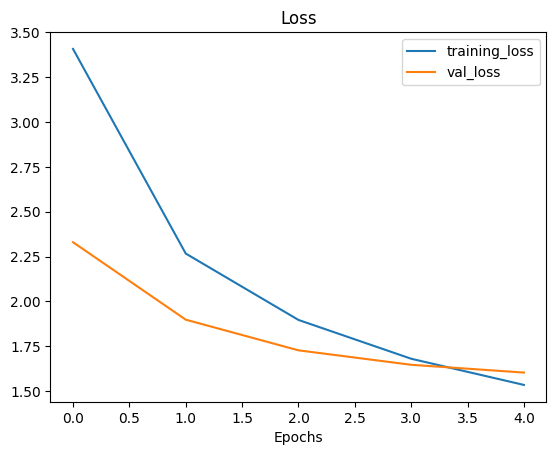

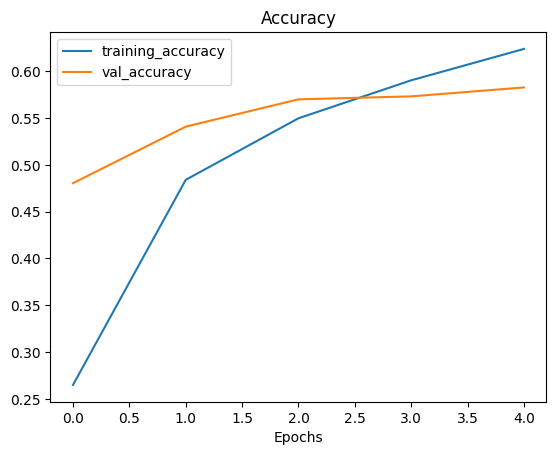

In [ ]:
plot_loss_curves(history_all_classes_10_percent)

## Fine-Tuning

In [ ]:
# Unfreeze all of the layers in the base model
# base_model.trainable = True
for layer in base_model.layers:
  layer.trainable = True

# Refreeze every layer except the last 15
# video says trainable layer should be 5
for layer in base_model.layers[:-5]:
    layer.trainable = False

In [ ]:
# Recompile model with lower learning rate typically best pracitce
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [ ]:
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 False
global_average_pooling True
output_layer True


In [ ]:
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer_3 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [ ]:
# Fine tune for more 5 epochs
fine_tune_epochs = 10 # model has already done 5 epochs


history_fine_tune = model.fit(train_data_all_10_percent,
                                epochs=fine_tune_epochs,
                                validation_data=test_data,
                                validation_steps=int(0.15*len(test_data)),
                                initial_epoch=history_all_classes_10_percent.epoch[-1]                                              )

Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 53s 169ms/step - accuracy: 0.6371 - loss: 1.5168 - val_accuracy: 0.5805 - val_loss: 1.5764
Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 172ms/step - accuracy: 0.6801 - loss: 1.3021 - val_accuracy: 0.5898 - val_loss: 1.5392
Epoch 7/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 36s 149ms/step - accuracy: 0.6922 - loss: 1.2345 - val_accuracy: 0.5959 - val_loss: 1.5064
Epoch 8/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 42s 152ms/step - accuracy: 0.7095 - loss: 1.1684 - val_accuracy: 0.6075 - val_loss: 1.4748
Epoch 9/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 173ms/step - accuracy: 0.7243 - loss: 1.1121 - val_accuracy: 0.6083 - val_loss: 1.4695
Epoch 10/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 76s 150ms/step - accuracy: 0.7484 - loss: 1.0312 - val_accuracy: 0.6131 - val_loss: 1.4599


In [ ]:
_all_classes_10_percent_fine_tuning_results = model.evaluate(test_data)
_all_classes_10_percent_fine_tuning_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 60s 76ms/step - accuracy: 0.0095 - loss: 4.6542


[4.656095504760742, 0.010574257001280785]

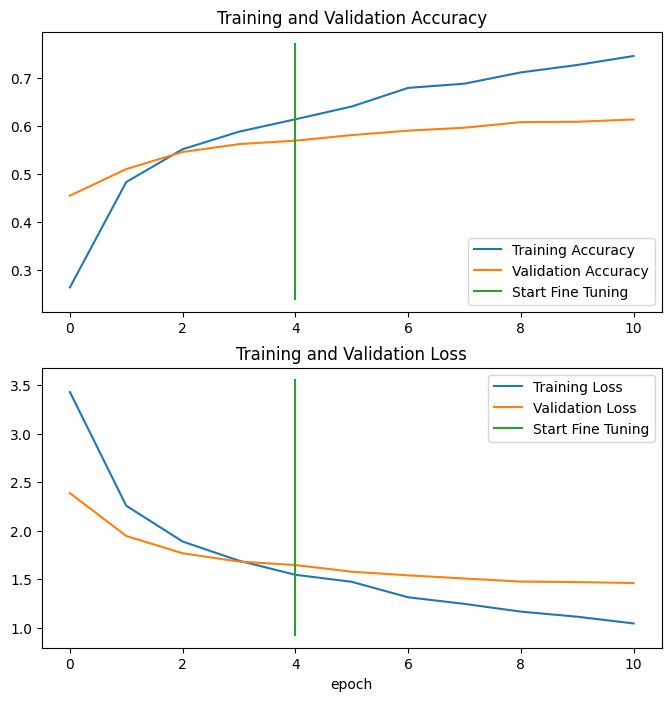

In [ ]:
# compare histories of feature extraction and fine-tuning
compare_historys(original_history=history_all_classes_10_percent,
                  new_history=history_fine_tune,
                  initial_epochs=5)

## Saving and Loading our model

To use our model in an external application, we'll need to save and export the model.

In [ ]:
# Save our first finie-tuning the model
model.save("drive/MyDrive/ML_Saved_Models/101_classes_10_percent_data_model_fine_tuned.keras")

In [ ]:
# Load and evaluate saved model
loaded_model = tf.keras.models.load_model("drive/MyDrive/ML_Saved_Models/101_classes_10_percent_data_model_fine_tuned.keras")
loaded_model.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 66s 76ms/step - accuracy: 0.6176 - loss: 1.4340


[1.4211502075195312, 0.6192474961280823]

## Evaluating the performance of the big dog model across all different classes

In [ ]:
import tensorflow as tf

# download pretrained model

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip



--2025-04-11 09:03:40--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.207, 172.217.194.207, 142.250.4.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  12.2MB/s    in 4.1s    

2025-04-11 09:03:44 (10.8 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [ ]:
unzip_data("/content/06_101_food_class_10_percent_saved_big_dog_model.zip")

In [ ]:
# Load in saved model
model = tf.keras.models.load_model("/content/drive/MyDrive/ML_Saved_Models/101_classes_10_percent_data_model_fine_tuned.keras")

In [ ]:
# Evaluate loaded model
results_loaded_model = model.evaluate(test_data)
results_loaded_model

790/790 ━━━━━━━━━━━━━━━━━━━━ 67s 78ms/step - accuracy: 0.6172 - loss: 1.4353


[1.421149492263794, 0.6192474961280823]

## Making pedictions with our trained model

In [ ]:
# Make predictions with model
preds_probs = model.predict(test_data, verbose=1)

790/790 ━━━━━━━━━━━━━━━━━━━━ 66s 81ms/step


In [ ]:
# How many predictions are there?
len(preds_probs)

25250

In [ ]:
# What's the shape of our predictions?
preds_probs.shape

(25250, 101)

In [ ]:
# Let's see what the frist predictions look like
preds_probs[:10]

array([[0.01377562, 0.00602944, 0.01532977, ..., 0.00636973, 0.01287901,
        0.00974898],
       [0.01338816, 0.00677618, 0.01387539, ..., 0.00692585, 0.01249331,
        0.01102199],
       [0.01448713, 0.00511608, 0.01694159, ..., 0.00556906, 0.01366714,
        0.00856822],
       ...,
       [0.01332692, 0.006709  , 0.0139044 , ..., 0.00714123, 0.01269782,
        0.01102055],
       [0.01423285, 0.00536765, 0.01663268, ..., 0.00578646, 0.01341123,
        0.00880744],
       [0.01388911, 0.00589998, 0.0154852 , ..., 0.00628251, 0.01304504,
        0.00964734]], dtype=float32)

In [ ]:
# Wat does the first prediction pobabiltiy array look like
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([0.01377562, 0.00602944, 0.01532977, 0.00709828, 0.00742018,
        0.00482658, 0.00987885, 0.01320054, 0.00913056, 0.01175622,
        0.00817684, 0.00839062, 0.0057941 , 0.00601965, 0.01002886,
        0.01647513, 0.00863398, 0.00888192, 0.01428168, 0.0112983 ,
        0.00946545, 0.00614012, 0.01169588, 0.00672661, 0.01490169,
        0.00511516, 0.00901305, 0.01461914, 0.01112497, 0.00894642,
        0.01527275, 0.00681703, 0.01044407, 0.00715623, 0.00974949,
        0.00654257, 0.00680564, 0.01481513, 0.01188247, 0.00894111,
        0.00863141, 0.01920989, 0.00770939, 0.00466192, 0.00793128,
        0.00623304, 0.01656188, 0.01261421, 0.00704617, 0.00786822,
        0.00840579, 0.0086019 , 0.01334517, 0.00862342, 0.0158028 ,
        0.01415138, 0.0071503 , 0.00949408, 0.00850302, 0.00646871,
        0.02013628, 0.00785508, 0.01089487, 0.01208802, 0.01525378,
        0.00557453, 0.01232167, 0.01709226, 0.01448461, 0.00593509,
        0.00841921, 0.01168332, 0.00598973, 0.00

Our model outputs a prediction probability array (with N number of variables, where N is the number of classes) for each sample passed to the predict method.

In [ ]:
# We get on prediction probability per class
print(f"Number of prediction probabilities fro sample 0: {len(preds_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {preds_probs[0]}")
print(f"The highest probability by the model for sample 0: {preds_probs[0].argmax()}")

Number of prediction probabilities fro sample 0: 101
What prediction probability sample 0 looks like:
 [0.01377562 0.00602944 0.01532977 0.00709828 0.00742018 0.00482658
 0.00987885 0.01320054 0.00913056 0.01175622 0.00817684 0.00839062
 0.0057941  0.00601965 0.01002886 0.01647513 0.00863398 0.00888192
 0.01428168 0.0112983  0.00946545 0.00614012 0.01169588 0.00672661
 0.01490169 0.00511516 0.00901305 0.01461914 0.01112497 0.00894642
 0.01527275 0.00681703 0.01044407 0.00715623 0.00974949 0.00654257
 0.00680564 0.01481513 0.01188247 0.00894111 0.00863141 0.01920989
 0.00770939 0.00466192 0.00793128 0.00623304 0.01656188 0.01261421
 0.00704617 0.00786822 0.00840579 0.0086019  0.01334517 0.00862342
 0.0158028  0.01415138 0.0071503  0.00949408 0.00850302 0.00646871
 0.02013628 0.00785508 0.01089487 0.01208802 0.01525378 0.00557453
 0.01232167 0.01709226 0.01448461 0.00593509 0.00841921 0.01168332
 0.00598973 0.0089881  0.00723065 0.00772224 0.00626602 0.00887411
 0.00832071 0.00863291 0.0

In [ ]:
test_data.class_names[60]

'lobster_bisque'

In [ ]:
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([57, 22, 51, 29, 43, 11, 25,  6,  3, 72])

In [ ]:
# How many pred classes do we have?
len(pred_classes)

25250

Now we've got a predictions array of all of our model's predictions, to evaluate them, we need to compare them to the labels.

In [ ]:
# to get  our test labels we need to unrave our test_data_BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) # Currently test labels look like: [0,,,1], we want to index where 1

y_labels[:10] # Look at the first 10

[np.int64(74),
 np.int64(44),
 np.int64(27),
 np.int64(57),
 np.int64(42),
 np.int64(65),
 np.int64(76),
 np.int64(89),
 np.int64(86),
 np.int64(57)]

In [ ]:
# How many y_labels are there
len(y_labels)

25250

## Evaluating our model's predictions

One way to check that our model's prediction array is in the same order as our test label array is to find accuracy score.

In [ ]:
# Let's try scikit-learns's accuracy score
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels, y_pred=pred_classes)
sklearn_accuracy

0.011603960396039604

In [ ]:
# Does this metric come close to our model's evaluate results
import numpy as np
np.isclose(results_loaded_model[1], sklearn_accuracy)

np.False_

## Let's get visual : making a confusion matrix

In [ ]:
from helper_functions import make_confusion_matrix

In [ ]:
# Get a list of class names
class_names= test_data.class_names

In [ ]:
# Edit make_confusion_matrix to print x-label vertically
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ## Changed (plot x-labels vertically) ##
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [ ]:
make_confusion_matrix(y_true=y_labels, y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100,100), text_size=20, savefig=True)

## Let's keep the evaluation train going, time for a classification report

Scikit-learn has a helpful function for acquiring many different classification metrics per class (e.g precision, recall and F1) called classification_report.

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels, y_pred=pred_classes, target_names=class_names))

                         precision    recall  f1-score   support

              apple_pie       0.02      0.01      0.01       250
         baby_back_ribs       0.01      0.01      0.01       250
                baklava       0.02      0.02      0.02       250
         beef_carpaccio       0.01      0.00      0.00       250
           beef_tartare       0.01      0.01      0.01       250
             beet_salad       0.02      0.02      0.02       250
               beignets       0.00      0.00      0.00       250
               bibimbap       0.02      0.02      0.02       250
          bread_pudding       0.01      0.04      0.02       250
      breakfast_burrito       0.01      0.02      0.01       250
             bruschetta       0.01      0.01      0.01       250
           caesar_salad       0.01      0.01      0.01       250
                cannoli       0.00      0.00      0.00       250
          caprese_salad       0.00      0.00      0.00       250
            carrot_cake 

The numbers above give a great class-by-class evaluation of our model's predictions. Let's visualize...

In [ ]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_true=y_labels, y_pred=pred_classes, target_names=class_names, output_dict=True)
classification_report_dict

{'apple_pie': {'precision': 0.017142857142857144,
  'recall': 0.012,
  'f1-score': 0.01411764705882353,
  'support': 250.0},
 'baby_back_ribs': {'precision': 0.0084985835694051,
  'recall': 0.012,
  'f1-score': 0.009950248756218905,
  'support': 250.0},
 'baklava': {'precision': 0.019305019305019305,
  'recall': 0.02,
  'f1-score': 0.019646365422396856,
  'support': 250.0},
 'beef_carpaccio': {'precision': 0.005714285714285714,
  'recall': 0.004,
  'f1-score': 0.004705882352941176,
  'support': 250.0},
 'beef_tartare': {'precision': 0.009950248756218905,
  'recall': 0.008,
  'f1-score': 0.008869179600886918,
  'support': 250.0},
 'beet_salad': {'precision': 0.0199203187250996,
  'recall': 0.02,
  'f1-score': 0.01996007984031936,
  'support': 250.0},
 'beignets': {'precision': 0.0035587188612099642,
  'recall': 0.004,
  'f1-score': 0.003766478342749529,
  'support': 250.0},
 'bibimbap': {'precision': 0.01639344262295082,
  'recall': 0.016,
  'f1-score': 0.016194331983805668,
  'support'

Let's plot all of our classes F1-Scores

In [ ]:
# Create empty dicitonayr
class_f1_score ={}
# Loop through classification report dictionary items
for k, v in classification_report_dict.items():
    # Check if key is not accuracy
    if k != 'accuracy':
        # Store class name and f1 score
        class_f1_score[k] = v['f1-score']

class_f1_score

{'apple_pie': 0.01411764705882353,
 'baby_back_ribs': 0.009950248756218905,
 'baklava': 0.019646365422396856,
 'beef_carpaccio': 0.004705882352941176,
 'beef_tartare': 0.008869179600886918,
 'beet_salad': 0.01996007984031936,
 'beignets': 0.003766478342749529,
 'bibimbap': 0.016194331983805668,
 'bread_pudding': 0.02027027027027027,
 'breakfast_burrito': 0.012759170653907496,
 'bruschetta': 0.009389671361502348,
 'caesar_salad': 0.012552301255230125,
 'cannoli': 0.0,
 'caprese_salad': 0.004081632653061225,
 'carrot_cake': 0.014519056261343012,
 'ceviche': 0.01642710472279261,
 'cheese_plate': 0.01279317697228145,
 'cheesecake': 0.01584786053882726,
 'chicken_curry': 0.007707129094412331,
 'chicken_quesadilla': 0.004032258064516129,
 'chicken_wings': 0.019455252918287938,
 'chocolate_cake': 0.012024048096192385,
 'chocolate_mousse': 0.011787819253438114,
 'churros': 0.0041753653444676405,
 'clam_chowder': 0.0039603960396039604,
 'club_sandwich': 0.016666666666666666,
 'crab_cakes': 0.0,

In [ ]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_score.keys()),
                          "f1_score": list(class_f1_score.values())}).sort_values("f1_score", ascending=False)
f1_scores

class_name  f1_score
37    filet_mignon  0.030151
32       dumplings  0.024000
52           gyoza  0.023121
96           tacos  0.022222
47         gnocchi  0.021552
..             ...       ...
50  grilled_salmon  0.000000
59         lasagna  0.000000
45   frozen_yogurt  0.000000
46    garlic_bread  0.000000
72        pancakes  0.000000

[103 rows x 2 columns]

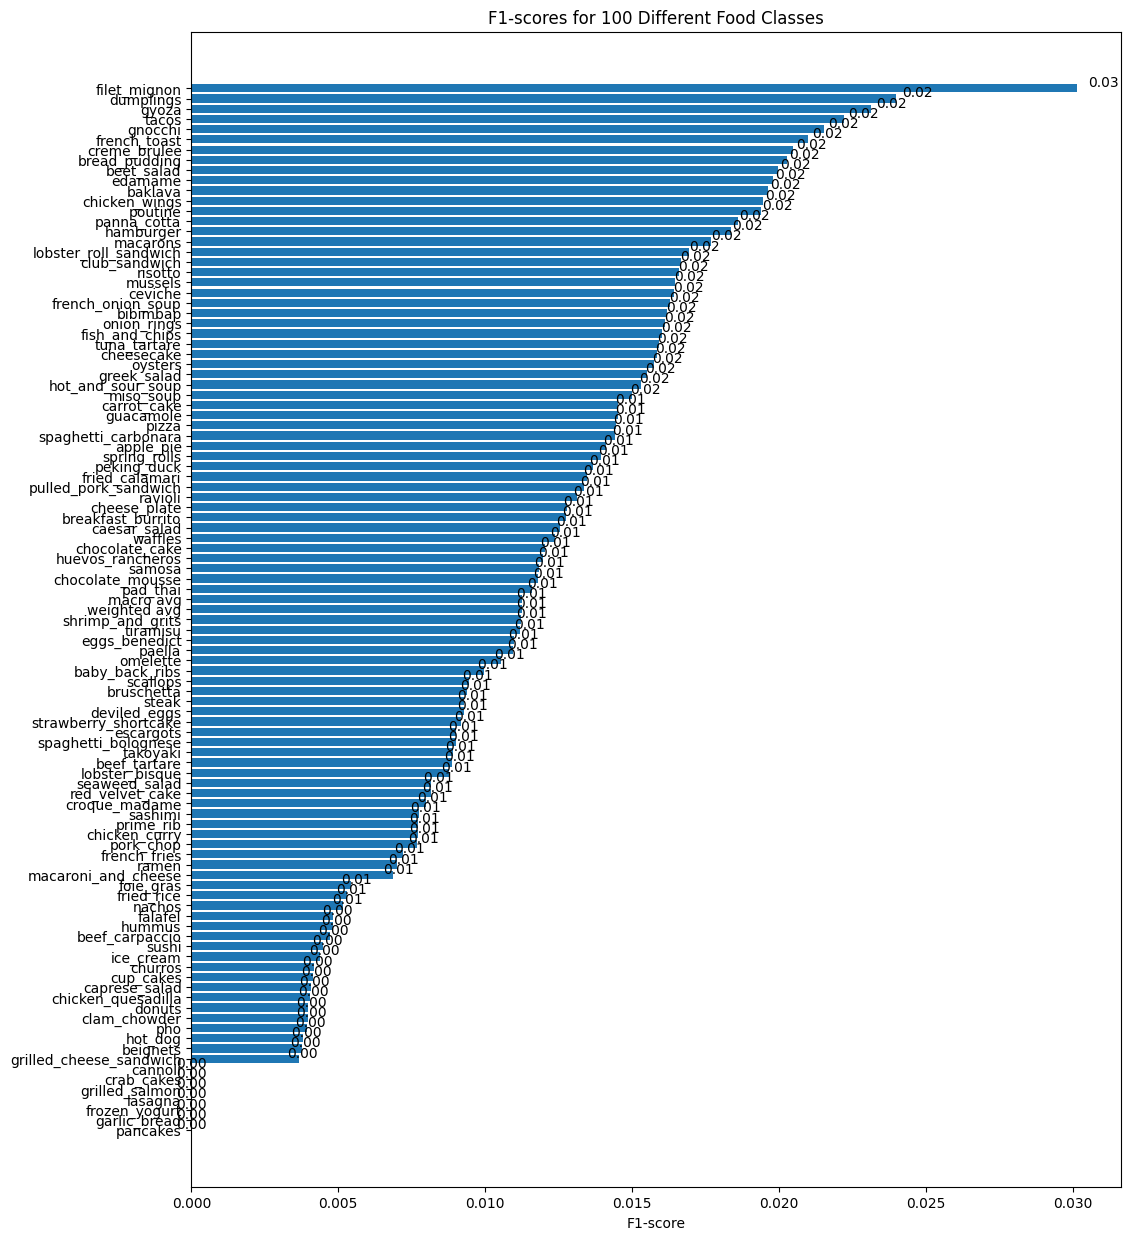

In [ ]:
import matplotlib.pyplot as plt

fix, ax= plt.subplots(figsize=(12, 15))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1_score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("F1-score")
ax.set_title("F1-scores for 100 Different Food Classes")
ax.invert_yaxis() # reverse the order

# Challenge: add values
def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)


## Visualizing predictions on test images

To visualize our model's predictions on our own images, we'll need a function to load and preprocess images, specifically it will need to:
* Read in a target image filepath using tf.io.read_file()
* Turn the image into a Tensor using tf.io.decode_image()
* Resize the image tensor to be the same size as the images our model has trained on using tf.image.resize()
* Scale the image to get all of the pixel values between 0 & 1 (if necessary)


In [ ]:
# Create a function to load and prepare images
def load_and_prep_image(filename, img_shape=334, scale=True):
  """
  Read in an image from filename, turns it into a tensor and reshapes into
  specified shape(ima_shape, img_sahape, color_channels).
  Args:
    filename (str): string filename of target image
    img_shape (int): height/width dimension of target image size
    scale (bool): whether to scale pixel values to range(0, 1), default True.
  Returns:
    Image tensor of shape (img_shape, img_shape, 3)
    """
  # Read in the image
  img = tf.io.read_file(filename)

  # Decode image into tensor, if image is 4 channel (like png), it forces to 3 channel
  img = tf.io.decode_image (img, channels=3)

  # Resize the image
  img = tf.image.resize(img, size=[img_shape, img_shape])

  if scale:
  # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

mage loading and preprocessing function ready.

Now let's write some code to:

1. Load a few random images from the test dataset.
2. Make predictions on them.
3. Plot the original image(s) along with the model's predicted label, prediction probability and ground truth label.

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


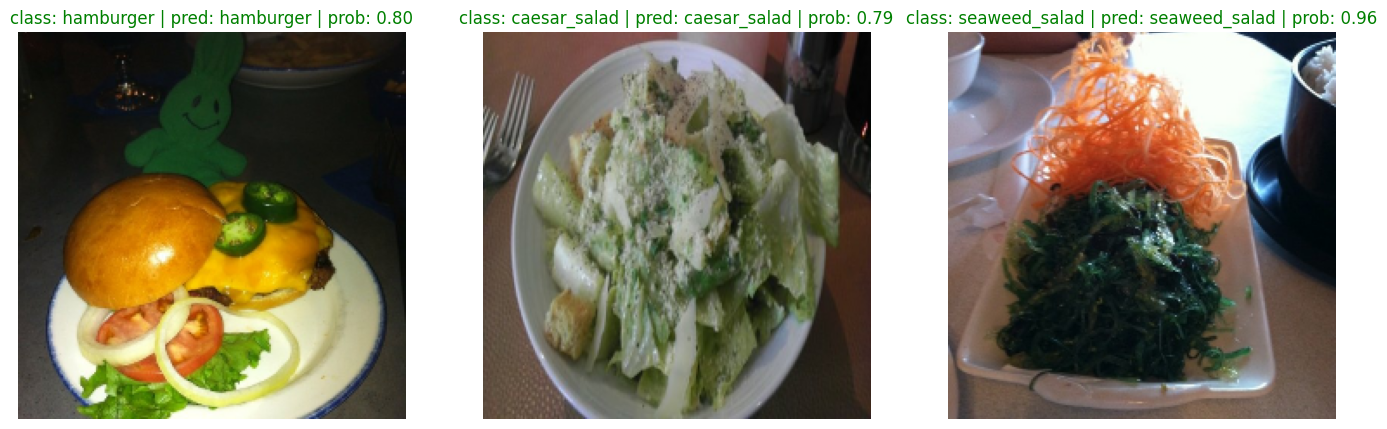

In [ ]:
# Make preds on a series of random images
import os
import random
from helper_functions import load_and_prep_image
plt.figure(figsize=(17,10))
for i in range (3):
  # Choose a random image from a random class
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + "/" + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNetBX models
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # need to expand dimension to make prediction on single image
  pred_class = class_names[pred_prob.argmax()] # find the predicted class

  # Plot the image alongside the prediction and truth label
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)

  if class_name == pred_class: # Color the title green if the prediction is right
    title_color = "g"
  else: # Color the title red if the prediction is wrong
    title_color = "r"

  plt.title(f"class: {class_name} | pred: {pred_class} | prob: {pred_prob.max():.2f}", color=title_color)
  plt.axis(False)

## Find the most wrong prediction

To find out where our model is most wrong, let's write some code to  find out the following:

1. Get all of the image file paths in the test dataset using list_files() method
2. Create a pandas DataFrame of the image filepaths, ground truth labels, predicted classes (from our model), max prediction probabilities, prediction class names and ground truth class names.
3. Use our DataFrame to find all the wrong predictions (where the ground truth label doesn't match the prediction).
4. Sort the DataFrame based on wrong predictions (have the highest prediction probability predictions at the top).
5. Visualize the images with the highest probabilities but have the wrong prediction.

In [ ]:
# 1. Get all of the image file paths in the dataset
filepaths = []
for filepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg",
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[0:10]

[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [ ]:

# 2. Create a DataFrame of filepaths and labels
pred_df = pd.DataFrame({"img_path": filepaths,
                   "y_true": y_labels,
                    "y_pred": pred_classes,
                   "pred_conf": preds_probs.max(axis=1),
                   "y_true_classname": [class_names[i] for i in y_labels],
                   "y_pred_classname": [class_names[i] for i in pred_classes],
                    })
pred_df

img_path  y_true  y_pred  \
0      b'/content/101_food_classes_10_percent/test/ap...      74      57   
1      b'/content/101_food_classes_10_percent/test/ap...      44      22   
2      b'/content/101_food_classes_10_percent/test/ap...      27      51   
3      b'/content/101_food_classes_10_percent/test/ap...      57      29   
4      b'/content/101_food_classes_10_percent/test/ap...      42      43   
...                                                  ...     ...     ...   
25245  b'/content/101_food_classes_10_percent/test/wa...      45      85   
25246  b'/content/101_food_classes_10_percent/test/wa...      39      37   
25247  b'/content/101_food_classes_10_percent/test/wa...      62      79   
25248  b'/content/101_food_classes_10_percent/test/wa...      71      73   
25249  b'/content/101_food_classes_10_percent/test/wa...      99      52   

       pred_conf     y_true_classname  y_pred_classname  
0       0.612873          peking_duck            hummus  
1       0.523830           fried_rice  chocolate_mousse  
2       0.997238         creme_brulee         guacamole  
3       0.998761               hummus         cup_cakes  
4       0.198578         french_toast    fried_calamari  
...          ...                  ...               ...  
25245   0.293802        frozen_yogurt            samosa  
25246   0.706787            foie_gras      filet_mignon  
25247   0.974740  macaroni_and_cheese         prime_rib  
25248   0.300933               paella       panna_cotta  
25249   0.282601         tuna_tartare             gyoza  

[25250 rows x 6 columns]

In [ ]:
# 3. Find our which predictions are wrong
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  y_true  y_pred  \
0  b'/content/101_food_classes_10_percent/test/ap...      74      57   
1  b'/content/101_food_classes_10_percent/test/ap...      44      22   
2  b'/content/101_food_classes_10_percent/test/ap...      27      51   
3  b'/content/101_food_classes_10_percent/test/ap...      57      29   
4  b'/content/101_food_classes_10_percent/test/ap...      42      43   

   pred_conf y_true_classname  y_pred_classname  pred_correct  
0   0.612873      peking_duck            hummus         False  
1   0.523830       fried_rice  chocolate_mousse         False  
2   0.997238     creme_brulee         guacamole         False  
3   0.998761           hummus         cup_cakes         False  
4   0.198578     french_toast    fried_calamari         False

In [ ]:
# 4. Sort out DataFrame to have most wrong predictions at the top
top_100_wrong = pred_df[pred_df["pred_correct"]==False].sort_values("pred_conf", ascending=False).head(100)
top_100_wrong.head(20)

img_path  y_true  y_pred  \
18044  b'/content/101_food_classes_10_percent/test/pa...      44      65   
10477  b'/content/101_food_classes_10_percent/test/fr...      48      65   
18202  b'/content/101_food_classes_10_percent/test/pa...       6      32   
10791  b'/content/101_food_classes_10_percent/test/fr...      60      32   
20263  b'/content/101_food_classes_10_percent/test/ra...      20      23   
16639  b'/content/101_food_classes_10_percent/test/na...      50      65   
10670  b'/content/101_food_classes_10_percent/test/fr...       1      32   
9564   b'/content/101_food_classes_10_percent/test/fi...      80      65   
1307   b'/content/101_food_classes_10_percent/test/be...      96      32   
14204  b'/content/101_food_classes_10_percent/test/hu...      99      65   
6415   b'/content/101_food_classes_10_percent/test/cl...      41      69   
7369   b'/content/101_food_classes_10_percent/test/cu...      73      32   
10851  b'/content/101_food_classes_10_percent/test/fr...      20      23   
14014  b'/content/101_food_classes_10_percent/test/hu...      66      32   
13687  b'/content/101_food_classes_10_percent/test/ho...      39      65   
106    b'/content/101_food_classes_10_percent/test/ap...      79      65   
12070  b'/content/101_food_classes_10_percent/test/gr...      50      32   
13776  b'/content/101_food_classes_10_percent/test/ho...      84      32   
12526  b'/content/101_food_classes_10_percent/test/gr...      78      65   
3589   b'/content/101_food_classes_10_percent/test/ca...      55      65   

       pred_conf      y_true_classname y_pred_classname  pred_correct  
18044   1.000000            fried_rice          mussels         False  
10477   0.999996           greek_salad          mussels         False  
18202   0.999996              beignets        dumplings         False  
10791   0.999992        lobster_bisque        dumplings         False  
20263   0.999992         chicken_wings          churros         False  
16639   0.999990        grilled_salmon          mussels         False  
10670   0.999990        baby_back_ribs        dumplings         False  
9564    0.999988  pulled_pork_sandwich          mussels         False  
1307    0.999985                 tacos        dumplings         False  
14204   0.999985          tuna_tartare          mussels         False  
6415    0.999982     french_onion_soup          oysters         False  
7369    0.999982           panna_cotta        dumplings         False  
10851   0.999982         chicken_wings          churros         False  
14014   0.999981                nachos        dumplings         False  
13687   0.999978             foie_gras          mussels         False  
106     0.999978             prime_rib          mussels         False  
12070   0.999974        grilled_salmon        dumplings         False  
13776   0.999974               risotto        dumplings         False  
12526   0.999972               poutine          mussels         False  
3589    0.999969               hot_dog          mussels         False

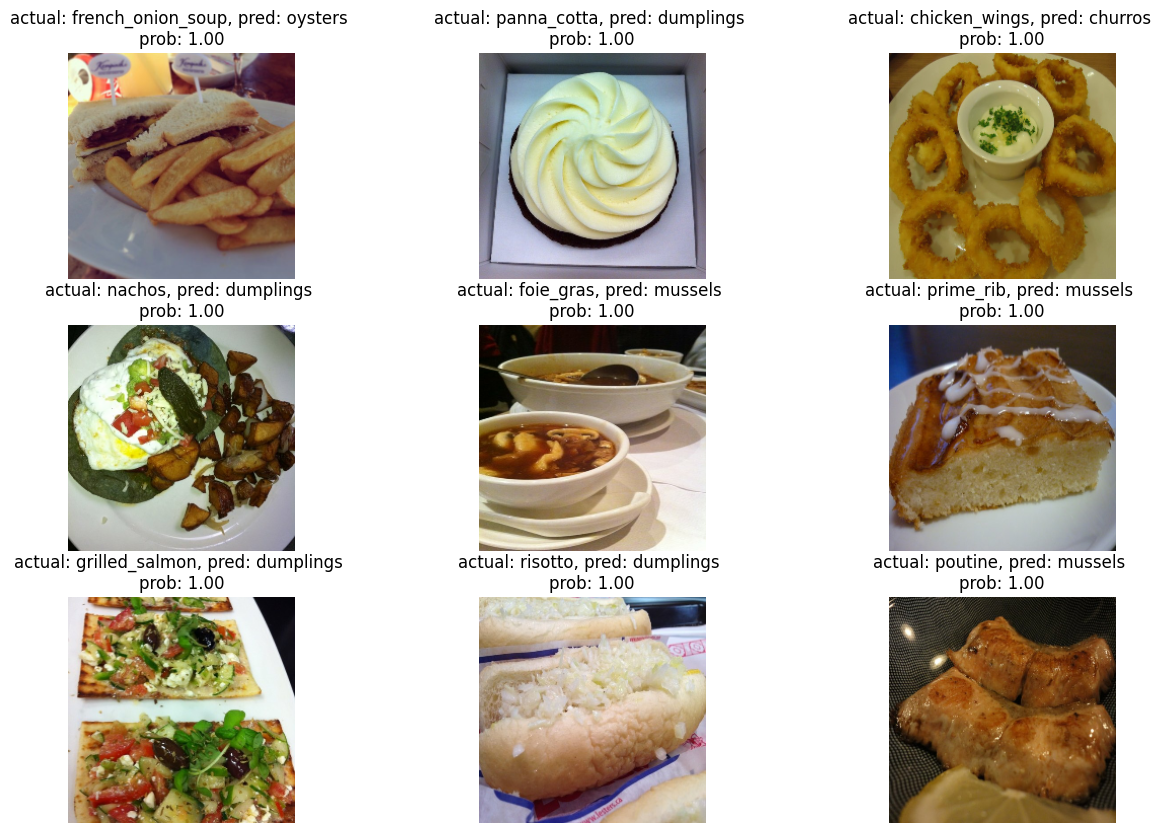

In [ ]:
# 5. visualize data samples which have wrong prediction but highest pred probability
images_to_view = 9
start_index = 10
plt.figure(figsize =(15,10))
for i, row in enumerate(top_100_wrong[start_index: start_index + images_to_view].itertuples()):
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=False) # row[1] is image path
  _, _, _, _, pred_prob, y_true, y_pred, _ = row # only interested in a few parameters of each row
  plt.imshow(img/255.)
  plt.title(f"actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}")
  plt.axis(False)

## Test out big dog model on our own custom images

In [ ]:
# Get custom images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
unzip_data("custom_food_images.zip")


--2025-04-11 09:58:08--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.207, 172.217.194.207, 142.250.4.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  6.97MB/s    in 1.8s    

2025-04-11 09:58:10 (6.97 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [ ]:
# Get the custom food images filepaths
custom_food_images = ["custom_food_images/"+ img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/chicken_wings.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/hamburger.jpeg']

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


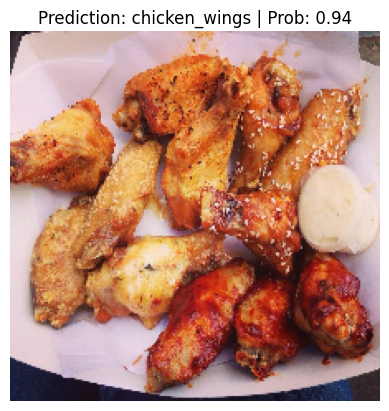

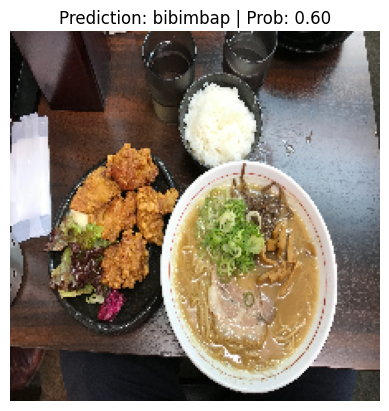

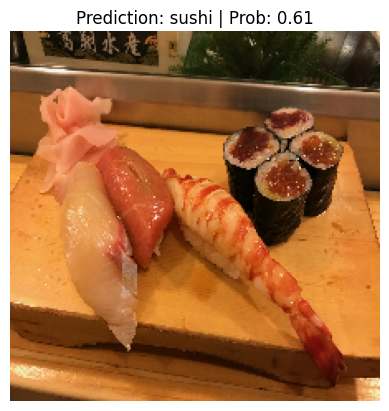

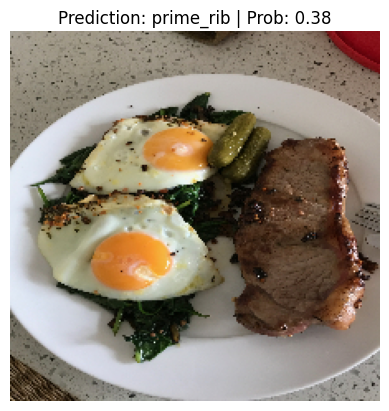

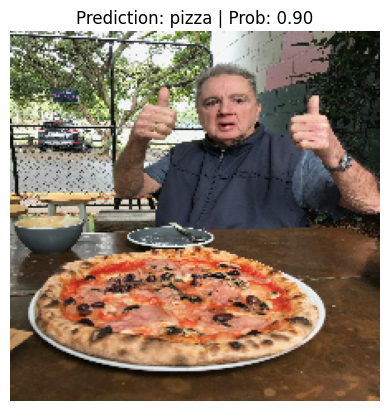

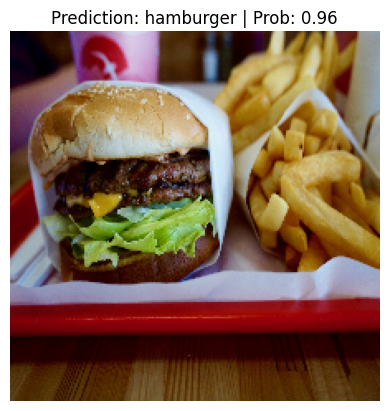

In [ ]:
# Make predictions on and plot custom food images
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) # don't scale images for EfficientNetBX models
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # need to expand dimension to make prediction on
  pred_class = class_names[pred_prob.argmax()] # find predicted class index and lookup prediction class name
  # Plot the appropiate information
  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"Prediction: {pred_class} | Prob: {pred_prob.max():.2f}")
  plt.axis(False)
